<a href="https://colab.research.google.com/github/DrashiDave/AQI-Prediction/blob/main/AQI_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


###**AIR QUALITY INSIGHTS: PREDICTING TRENDS AND INFLUENTIAL FACTORS IN URBAN ENVIRONMENTS**

### **DATASET OVERVIEW**:

Air Quality Realtime from Open Data DC: https://opendata.dc.gov/datasets/20c07bd1506249d4877ee45acfa73b71_76/explore


The dataset used in this project was sourced from Open Data DC, which provides publicly available environmental data. It includes air quality measurements collected from various monitoring sites across Washington, D.C.

The data covers six major monitoring sites in Washington, D.C., each identified by unique site names:
- Bald Eagle
- DCNearRoad
- TakomaRec
- McMillan Reservoir
- King Greenleaf Rec C
- RIVER Terrace


The original dataset includes a column named PARAMETERNAME, which containes all pollutant and parameter measurements recorded at a specific site and timestamp. Each pollutant (e.g., PM2.5, PM10, CO, NO2, OZONE) was represents as a separate row.

To prepare the data for analysis and modeling, I will pivot the dataset into a wide format, where:

  - Each pollutant will become a separate column.
  - Each row represented all pollutant measurements for a specific site and timestamp.

This transformation will allow us easier feature engineering and integration into machine learning models.

### **DATA IMPORT, EXPLORATION, AND CLEANING**

#### **Import Necessary Libraries**

In [ ]:
import pandas as pd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
import seaborn as sns
import folium
from IPython.display import display, IFrame

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### **Load and Read the dataset.**

In [ ]:
# Load and read the dataset
realtime_data_path = '/content/drive/My Drive/PROJECT/Air_Quality_Realtime.csv'
realtime_df = pd.read_csv(realtime_data_path)

In [ ]:
realtime_df.head()

,AQSID,SITENAME,PARAMETERNAME,DATETIME_LOCAL,REPORTINGUNITS,VALUE,DATASOURCE,OBJECTID
0,110010051,DCNearRoad,BARPR,2023/11/23 09:00:00+00,MILLIBAR,1010.4,District of Columbia - Department of Energy an...,1
1,110010051,DCNearRoad,BARPR,2023/11/23 10:00:00+00,MILLIBAR,1010.4,District of Columbia - Department of Energy an...,2
2,110010051,DCNearRoad,BARPR,2023/11/23 11:00:00+00,MILLIBAR,1011.7,District of Columbia - Department of Energy an...,3
3,110010051,DCNearRoad,BARPR,2023/11/23 12:00:00+00,MILLIBAR,1011.7,District of Columbia - Department of Energy an...,4
4,110010051,DCNearRoad,BARPR,2023/11/23 13:00:00+00,MILLIBAR,1013.1,District of Columbia - Department of Energy an...,5


#### **Check Missing Values.**

In [ ]:
realtime_df.isnull().sum()

,0
AQSID,0
SITENAME,0
PARAMETERNAME,0
DATETIME_LOCAL,0
REPORTINGUNITS,0
VALUE,0
DATASOURCE,0
OBJECTID,0


#### **Summary Statistics**

In [ ]:
# Summary statistics for numerical columns
print("Summary Statistics:")
realtime_df.describe()

Summary Statistics:


,AQSID,VALUE,OBJECTID
count,1.845550e+05,184555.000000,184555.000000
mean,6.316178e+10,66.822811,92278.000000
std,2.213328e+11,214.322393,53276.583803
min,1.100100e+08,-7.900000,1.000000
25%,1.100100e+08,2.800000,46139.500000
50%,1.100100e+08,7.800000,92278.000000
75%,1.100101e+08,25.000000,138416.500000
max,8.401100e+11,1038.400000,184555.000000


#### **Unique Values in Categorical Columns**

#### **Unique Parameter values**

In [ ]:
print(realtime_df['PARAMETERNAME'].unique())

['BARPR' 'CO' 'NO2' 'PM2.5' 'PRECIP' 'OZONE' 'PMC' 'RHUM' 'RWD' 'WS' 'RWS'
 'TEMP' 'PM10']


#### **Convert Timestamps**

In [ ]:
# Converting 'DATETIME_LOCAL' to datetime format
realtime_df['DATETIME_LOCAL'] = pd.to_datetime(realtime_df['DATETIME_LOCAL'])

### **DATA TRANSFORMATION**

#### **Group and Pivot the Data**

Transformed the dataset by grouping and pivoting. Created columns for each pollutant parameter and aggregate the values using the mean. This transformation prepares the data for AQI calculations.

In [ ]:
# Group and pivot the dataset
pivot_df = realtime_df.pivot_table(index=['SITENAME', 'DATETIME_LOCAL'],
                                   columns='PARAMETERNAME',
                                   values='VALUE',
                                   aggfunc='mean')  # You can change this to sum(), median(), etc.

# Reset the index for easier manipulation
pivot_df.reset_index(inplace=True)

In [ ]:
# Fill missing values by forward filling
pivot_df.fillna(method='ffill', inplace=True)

# Backfill for cases where forward fill cannot fill initial rows
pivot_df.fillna(method='bfill', inplace=True)


<ipython-input-74-75d6fec47b9b>:2: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

<ipython-input-74-75d6fec47b9b>:5: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [ ]:
pivot_df.head()

PARAMETERNAME,SITENAME,DATETIME_LOCAL,BARPR,CO,NO2,OZONE,PM10,PM2.5,PMC,PRECIP,RHUM,RWD,RWS,TEMP,WS
0,Bald Eagle,2024-04-02 05:00:00+00:00,1006.4,0.3,13.0,26.0,9.0,2.4,1.1,0.3,95.0,79.6,3.6,12.7,2.7
1,Bald Eagle,2024-04-02 06:00:00+00:00,1006.4,0.3,13.0,26.0,9.0,8.0,1.1,0.3,95.0,79.6,3.6,12.7,2.7
2,Bald Eagle,2024-04-02 07:00:00+00:00,1006.4,0.3,13.0,26.0,9.0,2.0,1.1,0.3,95.0,79.6,3.6,12.7,2.7
3,Bald Eagle,2024-04-02 08:00:00+00:00,1006.4,0.3,13.0,26.0,9.0,1.7,1.1,0.3,95.0,79.6,3.6,12.7,2.7
4,Bald Eagle,2024-04-02 09:00:00+00:00,1006.4,0.3,13.0,26.0,9.0,9.2,1.1,0.3,95.0,79.6,3.6,12.7,2.7


In [ ]:
# Checking if null values persist
pivot_df.isnull().sum()

,0
PARAMETERNAME,
SITENAME,0
DATETIME_LOCAL,0
BARPR,0
CO,0
NO2,0
OZONE,0
PM10,0
PM2.5,0
PMC,0


### **EDA**

EDA reveals insights into pollutant distributions and relationships between variables, helping to identify outliers and trends.



#### a. Visualize Pollutant Distributions

Creating visualizations to analyze the ranges and variability of pollutant levels. Identify any outliers or unusual patterns.

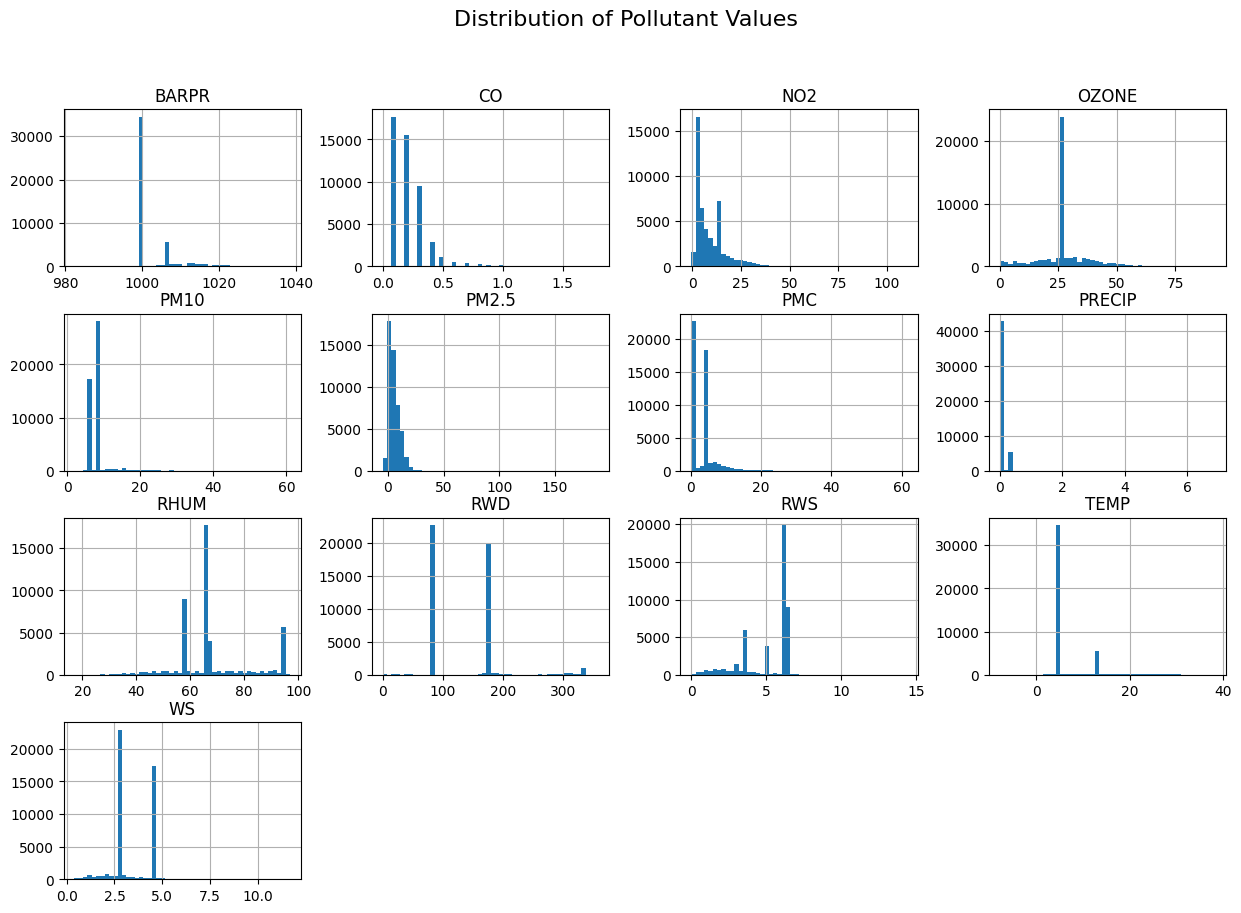

In [ ]:
# Plot the distribution of each parameter (pollutant)
pivot_df.drop(columns=['SITENAME', 'DATETIME_LOCAL']).hist(bins=50, figsize=(15, 10))
plt.suptitle('Distribution of Pollutant Values', fontsize=16)
plt.show()

#### b. Correlation Analysis

Investigating correlations between different pollutants and AQI to understand dependencies and interactions.



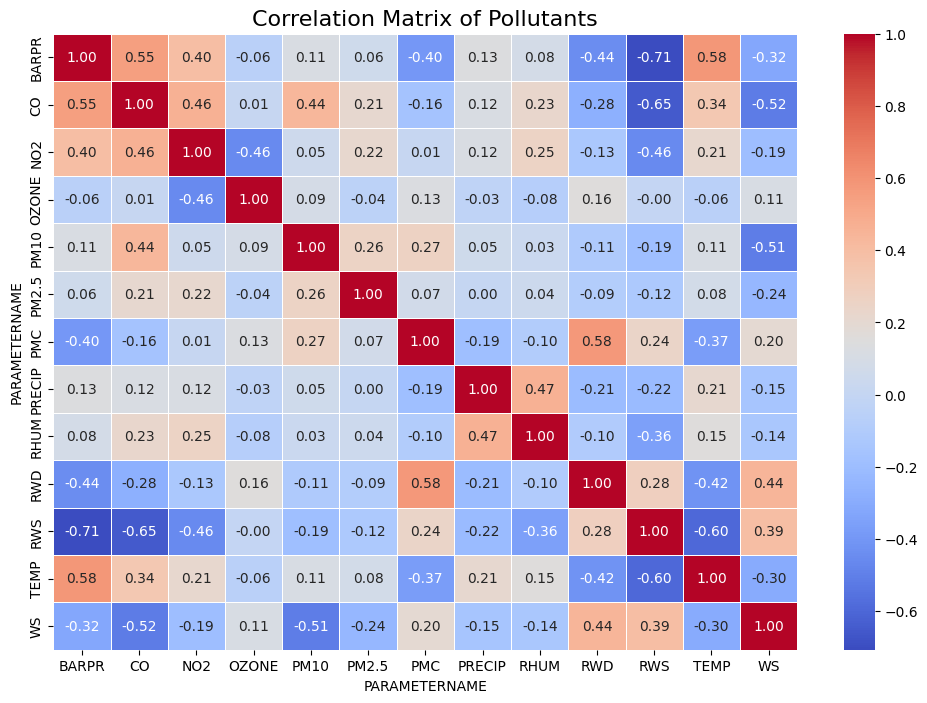

In [ ]:
# Plot a heatmap to visualize correlations between pollutants
corr_matrix = pivot_df.drop(columns=['SITENAME', 'DATETIME_LOCAL']).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Pollutants', fontsize=16)
plt.show()

### **CALCULATING AQI FOR EACH POLLUTANT**

#### **Applying AQI Calculation**

The Air Quality Index (AQI) quantifies air quality by combining sub-indices for individual pollutants (e.g., PM2.5, PM10, CO, NO₂, SO₂, O₃). Each sub-index is calculated based on pollutant concentration and breakpoints defined by AQI standards.

The formula for AQI sub-index is $I_p = \frac{I_{hi} - I_{lo}}{BP_{hi} - BP_{lo}} \times (C - BP_{lo}) + I_{lo}$.


Where:
*  C: Pollutant concentration
*  $BP_{hi}, BP_{lo}$: Breakpoints for 𝐶
*  $I_{hi}, I_{lo}$: AQI breakpoints for the range




In [ ]:
# AQI Calculation Function for Multiple Pollutants

def calculate_aqi(concentration, pollutant):
    # AQI breakpoints for each pollutant
    breakpoints = {
        'PM2.5': [(0, 12, 0, 50), (12.1, 35.4, 51, 100), (35.5, 55.4, 101, 150),
                  (55.5, 150.4, 151, 200), (150.5, 250.4, 201, 300), (250.5, 350.4, 301, 400),
                  (350.5, 500.4, 401, 500)],
        'PM10': [(0, 54, 0, 50), (55, 154, 51, 100), (155, 254, 101, 150),
                 (255, 354, 151, 200), (355, 424, 201, 300), (425, 504, 301, 400),
                 (505, 604, 401, 500)],
        'CO': [(0, 4.4, 0, 50), (4.5, 9.4, 51, 100), (9.5, 12.4, 101, 150),
               (12.5, 15.4, 151, 200), (15.5, 30.4, 201, 300), (30.5, 40.4, 301, 400),
               (40.5, 50.4, 401, 500)],
        'NO2': [(0, 53, 0, 50), (54, 100, 51, 100), (101, 360, 101, 150),
                (361, 649, 151, 200), (650, 1249, 201, 300), (1250, 2049, 301, 400),
                (2050, 4049, 401, 500)],
        'OZONE': [(0, 54, 0, 50), (55, 70, 51, 100), (71, 85, 101, 150),
                  (86, 105, 151, 200), (106, 200, 201, 300), (201, 400, 301, 400),
                  (401, 500, 401, 500)]
    }

    # Getting the breakpoints for the pollutant
    pollutant_breakpoints = breakpoints.get(pollutant, [])

    # Calculating AQI using breakpoints for the pollutant
    for lower, upper, aqi_low, aqi_high in pollutant_breakpoints:
        if lower <= concentration <= upper:
            # Calculate AQI using the formula
            aqi = aqi_low + (aqi_high - aqi_low) * (concentration - lower) / (upper - lower)
            return aqi
    return None


Applied the AQI calculation Function on each Pollutant and combined AQI values from all pollutants to create a unified Overall_AQI column.

In [ ]:
# Apply the AQI calculation to each pollutant
pivot_df['AQI_PM25'] = pivot_df['PM2.5'].apply(lambda x: calculate_aqi(x, 'PM2.5'))
pivot_df['AQI_PM10'] = pivot_df['PM10'].apply(lambda x: calculate_aqi(x, 'PM10'))
pivot_df['AQI_CO'] = pivot_df['CO'].apply(lambda x: calculate_aqi(x, 'CO'))
pivot_df['AQI_NO2'] = pivot_df['NO2'].apply(lambda x: calculate_aqi(x, 'NO2'))
pivot_df['AQI_OZONE'] = pivot_df['OZONE'].apply(lambda x: calculate_aqi(x, 'OZONE'))

# Calculate the overall AQI as the maximum AQI across all pollutants
pivot_df['Overall_AQI'] = pivot_df[['AQI_PM25', 'AQI_PM10', 'AQI_CO', 'AQI_NO2', 'AQI_OZONE']].max(axis=1)

#### **Visualize AQI Trends**

Generating trend plots for overall AQI over time. For example, analyze data trends at a specific site like the "Bald Eagle Site."

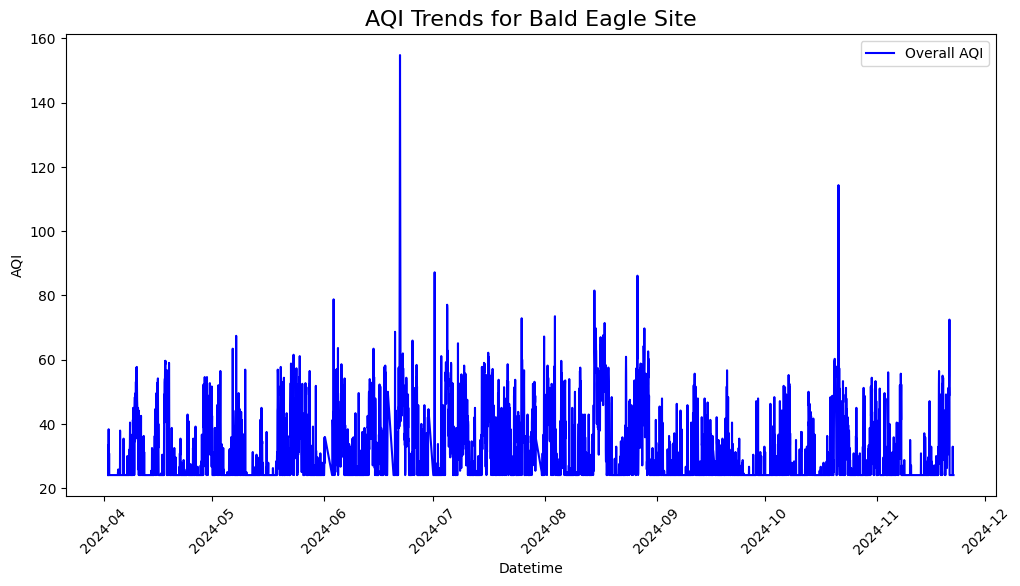

In [ ]:
# Visualizing the AQI trends for a specific site (e.g., 'Bald Eagle')
site_aqi_trends = pivot_df[pivot_df['SITENAME'] == 'Bald Eagle'][['DATETIME_LOCAL', 'Overall_AQI']]
site_aqi_trends.set_index('DATETIME_LOCAL', inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(site_aqi_trends.index, site_aqi_trends['Overall_AQI'], label='Overall AQI', color='blue')
plt.title('AQI Trends for Bald Eagle Site', fontsize=16)
plt.xlabel('Datetime')
plt.ylabel('AQI')
plt.xticks(rotation=45)
plt.legend()
plt.show()

### **FEATURE ENGINEERING FOR MODELLING**

#### **Check for Null Values**

In [ ]:
# Replace nulls with mean
pivot_df['AQI_PM25'] = pivot_df['AQI_PM25'].fillna(pivot_df['AQI_PM25'].mean())
pivot_df['AQI_NO2'] = pivot_df['AQI_NO2'].fillna(pivot_df['AQI_NO2'].mean())

In [ ]:
pivot_df.isnull().sum()

,0
PARAMETERNAME,
SITENAME,0
DATETIME_LOCAL,0
BARPR,0
CO,0
NO2,0
OZONE,0
PM10,0
PM2.5,0
PMC,0


#### **Creating New Features (Cyclical Encoding)**

We create new features to enhance the predictive power of our models, including cyclical time encoding to capture temporal patterns.


In [ ]:
def add_cyclical_features(df):

    df['month'] = df['DATETIME_LOCAL'].dt.month
    df['day_of_year'] = df['DATETIME_LOCAL'].dt.dayofyear
    df['hour'] = df['DATETIME_LOCAL'].dt.hour

    # Cyclical encoding
    df['month_sin'] = np.sin(df['month'] * (2 * np.pi / 12))
    df['month_cos'] = np.cos(df['month'] * (2 * np.pi / 12))
    df['day_sin'] = np.sin(df['day_of_year'] * (2 * np.pi / 365))
    df['day_cos'] = np.cos(df['day_of_year'] * (2 * np.pi / 365))
    df['hour_sin'] = np.sin(df['hour'] * (2 * np.pi / 24))
    df['hour_cos'] = np.cos(df['hour'] * (2 * np.pi / 24))

    return df

# Applying cyclical encoding to enhance features
pivot_df = add_cyclical_features(pivot_df)

#### **Geospatial Visualization**

We visualize AQI levels across different sites using geospatial mapping. This will allow us to map out the AQI for each site and assess the distribution of air quality across locations.

In [ ]:
# We need to find the unique values in the 'SITENAME' column
pivot_df['SITENAME'].unique()

array(['Bald Eagle', 'DCNearRoad', 'King Greenleaf Rec C',
       'McMillan Reservoir', 'RIVER_Terrace', 'TakomaRec'], dtype=object)

In [ ]:
# Defining site coordinates
site_coordinates = {
    'Bald Eagle': (38.8456, -76.9787),
    'DCNearRoad': (38.8951, -77.0364),
    'TakomaRec': (38.9754, -77.0197),
    'King Greenleaf Rec C': (38.8750, -77.0128),
    'McMillan Reservoir': (38.9242, -77.0124),
    'RIVER_Terrace': (38.8946, -76.9699)
}

# Add latitude and longitude to DataFrame
pivot_df['Latitude'] = pivot_df['SITENAME'].map(lambda x: site_coordinates.get(x, (None, None))[0])
pivot_df['Longitude'] = pivot_df['SITENAME'].map(lambda x: site_coordinates.get(x, (None, None))[1])

# Aggregate AQI by site
site_aqi_summary = pivot_df.groupby('SITENAME')[['Overall_AQI', 'Latitude', 'Longitude']].mean().reset_index()

In [ ]:
# Creating the geospatial map
def create_aqi_map(site_summary):
    def get_aqi_color(aqi):
        if aqi <= 50:
            return 'green'
        elif aqi <= 100:
            return 'yellow'
        elif aqi <= 150:
            return 'orange'
        elif aqi <= 200:
            return 'red'
        else:
            return 'purple'


    m = folium.Map(location=[site_summary['Latitude'].mean(), site_summary['Longitude'].mean()], zoom_start=10)
    for _, row in site_summary.iterrows():
        folium.CircleMarker(
            location=[row['Latitude'], row['Longitude']],
            radius=10,
            popup=f"{row['SITENAME']}: AQI {row['Overall_AQI']:.2f}",
            color=get_aqi_color(row['Overall_AQI']),
            fill=True,
            fillColor=get_aqi_color(row['Overall_AQI'])
        ).add_to(m)

    return m

# Generating and display the map inline
create_aqi_map(site_aqi_summary)

#### **Early Warning System**

Implementing the Early Warning System based on rolling statistics (mean and standard deviation) of AQI values to generate alerts for sudden changes in air quality. These alerts include:

  * High Risk: Sudden AQI increase.
  * Warning: Unhealthy air quality.
  * Caution: Gradual AQI increase.
  * Normal: No significant change.

In [ ]:
def create_early_warning_system(df, window=24):

    df_sorted = df.sort_values('DATETIME_LOCAL')
    df_sorted['AQI_rolling_mean'] = df_sorted['Overall_AQI'].rolling(window=window).mean()
    df_sorted['AQI_rolling_std'] = df_sorted['Overall_AQI'].rolling(window=window).std()

    def generate_warning(row):
        if row['Overall_AQI'] > row['AQI_rolling_mean'] + 2 * row['AQI_rolling_std']:
            return 'High Risk: Sudden AQI Increase'
        elif row['Overall_AQI'] > 100:
            return 'Warning: Unhealthy Air Quality'
        elif row['Overall_AQI'] > row['AQI_rolling_mean'] + row['AQI_rolling_std']:
            return 'Caution: Gradual AQI Increase'
        else:
            return 'Normal'

    df_sorted['AQI_Warning'] = df_sorted.apply(generate_warning, axis=1)
    return df_sorted

In [ ]:
# Applying the early warning system
pivot_df = create_early_warning_system(pivot_df)

In [ ]:
# Visualizing warnings distribution
warnings_summary = pivot_df['AQI_Warning'].value_counts().reset_index()
warnings_summary.columns = ['Warning Type', 'Count']

# Bar chart using Plotly
fig = px.bar(warnings_summary,
             x='Warning Type',
             y='Count',
             color='Warning Type',
             color_discrete_map={'High Risk: Sudden AQI Increase': 'orange',
                                 'Warning: Unhealthy Air Quality': 'red',
                                 'Caution: Gradual AQI Increase': 'yellow',
                                 'Normal': 'green'},
             title='Distribution of AQI Warnings',
             labels={'Warning Type': 'Warning Type', 'Count': 'Count of Warnings'})

fig.update_layout(xaxis_title='Warning Type', yaxis_title='Count of Warnings')
fig.show()

### **DATA PREPROCESSING FOR MODEL BUILDING**


Data preprocessing prepares the data for modeling by performing operations like splitting the data, encoding categorical variables, and normalizing features.


#### **Splitting Data into Training and Testing Sets**

Dividing the dataset into training and testing subsets for model evaluation.

In [ ]:
# Defining the feature set (independent variables) and target variable (dependent variable)
X = pivot_df[['PM2.5', 'PM10', 'CO', 'NO2', 'OZONE', 'RHUM', 'RWD', 'RWS', 'TEMP', 'WS',
              'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos']]
y = pivot_df['Overall_AQI']

#### **Train-Test Split**

Spliting the dataset into 80% training and 20% testing

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### **Scaling Features**

Standardize feature values for consistency in model training.

In [ ]:
# Scale the features
scaler = StandardScaler()

# Fit the scaler to the training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### **MODEL COMPARISION PIPELINE**


In this step, we will compare different regression models to identify the best-performing one for AQI prediction.  
The models include:
- Random Forest Regressor
- Gradient Boosting Regressor
- Linear Regression
- Support Vector Regressor (SVR)

We will evaluate the models based on **Mean Squared Error (MSE)** and **R-squared (R²)** scores.

#### **Defining the models to compare**

We start by defining the models we want to compare. These models will help us evaluate different approaches to predicting AQI.


In [ ]:
# Defining models to compare
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "Linear Regression": LinearRegression(),
    "SVR": SVR(kernel='rbf')
}

#### **Creating dictionary to store the results and Comparing the models**

We will now train and evaluate each model using Mean Squared Error (MSE) and R-squared (R²) metrics. These results will be stored in a dictionary and converted into a DataFrame for easier visualization.

In [ ]:
# Dictionary to store results
results = {}

# Compare models
for name, model in models.items():
    # Train the model
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = model.predict(X_test_scaled)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Store results
    results[name] = {
        "MSE": mse,
        "R²": r2
    }

In [ ]:
# Converting results to DataFrame for better visualization
results_df = pd.DataFrame(results).T

#### **Displaying Results for Model Comparision**

In [ ]:
# Displaying results
print("Model Comparison Results:")
print(results_df)

Model Comparison Results:
                         MSE        R²
Random Forest       0.407452  0.997943
Gradient Boosting   0.997483  0.994965
Linear Regression  42.892583  0.783497
SVR                13.100856  0.933873


In [ ]:
# Identifying the best model
best_model_name = results_df['R²'].idxmax()
best_model = models[best_model_name]
print(f"The best model is: {best_model_name} with R²: {results_df.loc[best_model_name, 'R²']:.4f}")

The best model is: Random Forest with R²: 0.9979


### **CHOOSING THE BEST MODEL FOR AQL PREDICTION: *RANDOM FOREST***

Based on the model comparison in the previous Step, we will select the best-performing model.  
The selected model will be used for final predictions and integration into the dashboard.

In [ ]:
# Predicting AQI values using the Random Forest model
y_pred_best = best_model.predict(X_test_scaled)

In [ ]:
#DataFrame to store the results
prediction_results = pd.DataFrame({
    'Actual AQI': y_test,
    'Predicted AQI': y_pred_best
})

In [ ]:
# First few rows of the prediction results
prediction_results.head()

,Actual AQI,Predicted AQI
45171,54.266667,54.266667
45855,34.259259,34.259259
45220,45.370370,45.370370
22804,29.166667,29.166667
41127,8.962264,8.976415


### **AIR QUALITY CLASSIFICATION BASED ON THE PREDICTED AQI**

Now that we've trained and evaluated our best model (Random Forest), we will classify the predicted AQI values into different categories such as Good, Moderate, Unhealthy, etc. This classification will help us understand the air quality levels based on the predicted AQI values.


In [ ]:
# Function to categorize AQI levels
def categorize_aqi(aqi_value):
    if aqi_value <= 50:
        return 'Good'
    elif 51 <= aqi_value <= 100:
        return 'Moderate'
    elif 101 <= aqi_value <= 150:
        return 'Unhealthy for Sensitive Groups'
    elif 151 <= aqi_value <= 200:
        return 'Unhealthy'
    elif 201 <= aqi_value <= 300:
        return 'Very Unhealthy'
    else:
        return 'Hazardous'

In [ ]:
# Applying the categorization function to the predicted AQI values
predicted_categories = [categorize_aqi(x) for x in y_pred_best]

In [ ]:
# Creating a DataFrame with the predicted AQI and the corresponding category
classification_results = pd.DataFrame({
    "Predicted AQI": y_pred_best,
    "Predicted Category": predicted_categories
})

In [ ]:
# Displaying the classification results
classification_results.head()

,Predicted AQI,Predicted Category
0,54.266667,Moderate
1,34.259259,Good
2,45.370370,Good
3,29.166667,Good
4,8.976415,Good


### **VISUALIZING AQI PREDICTIONS AND CATEGORIES USING PLOTLY**

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

#### **Plot for Actual vs Predicted AQI**

In [ ]:
# Plotting a scatter plot for Actual vs Predicted AQI
fig = px.scatter(prediction_results, x="Actual AQI", y="Predicted AQI",
                 title="Actual vs Predicted AQI",
                 labels={"Actual AQI": "Actual AQI", "Predicted AQI": "Predicted AQI"})

# Show the regression line
fig.add_trace(go.Scatter(x=prediction_results["Actual AQI"], y=prediction_results["Actual AQI"],
                         mode='lines', name='Regression Line', line=dict(color='red', dash='dash')))

fig.show()

The scatter plot comparing actual and predicted AQI values demonstrates the Random Forest Regressor's performance. The points lie closely along the regression line, indicating a strong alignment between predicted and actual values, reflecting a nearly perfect R² value of 0.99. This result showcases the model's exceptional predictive capability for continuous AQI values.

#### **Bar chart for the distribution of AQI Categories**

In [ ]:
# Plotting a bar chart for the distribution of AQI Categories
category_counts = classification_results['Predicted Category'].value_counts().reset_index()
category_counts.columns = ['AQI Category', 'Count']
fig2 = px.bar(category_counts,
             x='AQI Category',
             y='Count',
             color='AQI Category',
             title="Distribution of AQI Categories",
             labels={'AQI Category': 'AQI Category', 'Count': 'Count of Categories'})

fig2.show()

The bar chart illustrates the distribution of predicted air quality categories across the dataset. Categories such as Good, Moderate, Unhealthy for Sensitive Groups, and Unhealthy are shown with their respective counts. The majority of data points fall under the Good and Moderate categories, reflecting overall better air quality for most locations. However, the presence of other categories highlights localized or temporal deteriorations in air quality that warrant further investigation.

#### **Line chart for AQI trends**

In [ ]:
# Line chart for AQI trends
fig = px.line(
    pivot_df,
    x='DATETIME_LOCAL',
    y='Overall_AQI',
    title='Overall AQI Trends Over Time',
    markers=True
)
fig.show()

The time-series line plot illustrates the AQI trends over time for the dataset. It provides valuable insights into temporal changes in air quality, helping policymakers and researchers understand fluctuations across different time periods​.

#### **Plot for pollutant contributions**

In [ ]:
# Bar chart for pollutant contributions
pollutants = ['PM2.5', 'PM10', 'CO', 'NO2', 'OZONE']
df_pollutants = pivot_df[pollutants].mean().reset_index()
df_pollutants.columns = ['Pollutant', 'Mean Level']

fig = px.bar(
    df_pollutants,
    x='Pollutant',
    y='Mean Level',
    title='Average Pollutant Levels'
)
fig.show()

The bar chart showing the average levels of pollutants (e.g., PM2.5, PM10, CO, NO2, OZONE) highlights their contributions to overall air quality. Among the pollutants, PM2.5 and PM10 exhibit the highest average concentrations, indicating their significant impact on AQI. These insights emphasize the need for targeted measures to control these key pollutants, which are critical to improving urban air quality.

#### **Feature Importance Plot**

In [ ]:
# feature list
pollutant_features = ['PM2.5', 'PM10', 'CO', 'NO2', 'OZONE']


# DataFrame for feature importances
pollutant_importances = best_model.feature_importances_[:5]

# DataFrame for visualization
importance_df = pd.DataFrame({
    "Pollutant": pollutant_features,
    "Importance": pollutant_importances
})

# Plot the feature importances using Plotly
fig = px.bar(importance_df,
             x="Pollutant",
             y="Importance",
             title="Feature Importance for Pollutants in AQI Prediction",
             labels={"Pollutant": "Pollutant", "Importance": "Feature Importance"},
             color="Importance",
             color_continuous_scale='Viridis')

# Show the plot
fig.show()

The Feature Importance Plot clearly shows that PM2.5, Ozone, and NO2 pollutants have the greatest influence on AQI prediction. The chart highlights the relative importance of each pollutant, helping stakeholders understand the factors contributing most to air quality levels.

### **CONCLUSION AND INSIGHTS**

In this project, the **CRISP-DM methodology** was applied to predict **AQI levels** and classify **air quality** in urban areas, with a focus on key pollutants such as **PM2.5**, **PM10**, **CO**, **NO2**, and **OZONE**. The project progressed through several stages: understanding the data, preparing it, building machine learning models, and interpreting the results.

- Key pollutants like **PM2.5**, **OZONE**, and **NO2** were found to have the most significant impact on AQI levels, suggesting that controlling these pollutants could be crucial for improving air quality.

- The **early warning system** implemented in the project allows for proactive responses to potential AQI deterioration by providing **high-risk alerts** based on changes in air quality patterns.

- By using **cyclical time encoding**, the model’s performance was improved by capturing the **seasonality** in AQI data, while **geospatial visualization** provided insights into the **spatial distribution** of air quality issues across urban sites.

Overall, the project successfully demonstrated the power of **machine learning** in predicting future AQI values and classifying air quality levels, providing valuable tools for **policymakers** and **the public** to take informed action.
